In [522]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import math

In [523]:
data = pd.read_csv("data_session_1000.csv")
data.describe()

,Session,Product_id,Num_bought
count,48169.000000,48169.000000,48169.000000
mean,503.207914,501.644855,0.094937
std,289.707249,287.946803,0.303363
min,0.000000,0.000000,0.000000
25%,256.000000,253.000000,0.000000
50%,502.000000,501.000000,0.000000
75%,758.000000,751.000000,0.000000
max,999.000000,999.000000,4.000000


In [524]:
# Only use the bought products 
data_bought = data[data['Num_bought']>0]
data_bought.describe()

,Session,Product_id,Num_bought
count,4433.00000,4433.000000,4433.000000
mean,503.48139,334.419355,1.031581
std,288.44904,201.927328,0.183711
min,0.00000,2.000000,1.000000
25%,260.00000,147.000000,1.000000
50%,509.00000,330.000000,1.000000
75%,756.00000,521.000000,1.000000
max,999.00000,662.000000,4.000000


In [525]:
data_rp = data_bought.pivot(index='Session', columns='Product_id', values='Num_bought')

### 1. train, test split 


In [526]:
#Using the first 500 session as input 
#and the last 500 session ,product_id <=100 as the test
data_rp = data_rp.fillna(0)
data_rp = data_rp.astype('int')

#using the first 100 session and product_id <=100 as the test set
final_check = data_rp.loc[:100,:100].copy()
#final_check

In [527]:
# change the test data as the missing values; assign = 0
data_rp.loc[:100,:100] = 0

### 2. Train model with weighted least square 

In [528]:
Q = data_rp.values
Q

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [529]:
Q.shape

(498, 181)

In [530]:
import numpy as np

W = Q>=1
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)
W

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [531]:
# parameters: 
lambda_ = 0.01
n_factors = 10
m, n = Q.shape
n_iterations = 20

X = 5 * np.random.rand(m, n_factors) 
Y = 5 * np.random.rand(n_factors, n)

In [532]:
#using W matix: 
#in order of get rid of the missing values from the least squa
def get_error(Q, X, Y, W):
    return np.sum((W * (Q - np.dot(X, Y)))**2)

In [533]:
weighted_errors = []
for ii in range(n_iterations):
    for u, Wu in enumerate(W):
        X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors),
                               np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
    for i, Wi in enumerate(W.T):
        Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors),
                                 np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
    weighted_errors.append(get_error(Q, X, Y, W))
    #print('{}th iteration is completed'.format(ii))
weighted_Q_hat = np.dot(X,Y)
print('Error of brought products: {}'.format(get_error(Q, X, Y, W)))

Error of brought products: 1.0653440668149814


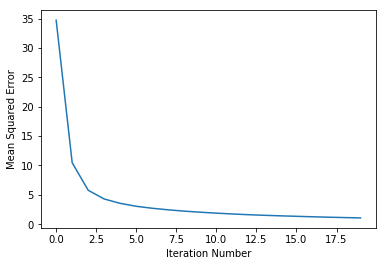

In [534]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(weighted_errors);
plt.xlabel('Iteration Number');
plt.ylabel('Mean Squared Error');

In [535]:
weighted_Q_hat

array([[ 1.02357674,  0.7829922 ,  0.95449884, ...,  1.03327809,
         1.09989636,  0.86865562],
       [ 0.98694234,  0.88729734,  0.91210205, ...,  1.00861774,
         1.00287855,  1.02044438],
       [ 1.0285836 ,  1.06896988,  0.71115235, ...,  0.94713178,
         0.97603827,  1.05434601],
       ..., 
       [ 1.01495853,  0.92669686,  0.86958691, ...,  1.08663502,
         1.01993028,  1.04549174],
       [ 1.12477562,  1.0984696 ,  0.93906184, ...,  1.33773993,
         0.93302602,  1.17933085],
       [ 0.95995453,  0.85301405,  0.88010362, ...,  1.00843212,
         0.98560645,  0.98976798]])

In [536]:
predictions = pd.DataFrame(weighted_Q_hat)
predictions.shape

(498, 181)

In [537]:
true_values = pd.DataFrame(Q)
true_values.shape

(498, 181)

In [538]:
test_size_r,test_size_c = final_check.shape
print(test_size_r,test_size_c)

55 28


### 3. evaluate train data using MRR

In [539]:
"""
evaluate the first part of the train data using MRR
"""
train_c_name1 = ["p_"+str(i) for i in range(test_size_c,n)]
train_predictions1 = predictions.loc[0:test_size_r-1,test_size_c:]
train_predictions1.columns = train_c_name1
#train_predictions1

train_true1 = true_values.loc[0:test_size_r-1,test_size_c:]
train_true1.columns = train_c_name1
#train_true1

In [540]:
mrr_list1 = []
for i in range(test_size_r):
    session_i = train_true1.loc[i]
    session_i_new = session_i[session_i>0]
    session_i_index = list(session_i_new.index)
    
    test_i = train_predictions1.loc[i]
    test_i_rank = test_i.sort_values(ascending = False)
    test_i_index = list(test_i_rank.index)
    
    if len(session_i_index) != 0:
        list_rr = []
        for product_real in session_i_index:
            index = test_i_index.index(product_real)
            rank = index+1
            RR = 1/rank
            list_rr.append(RR)
        mrr = np.mean(list_rr)
        mrr_list1.append(mrr)
#print(mrr_list1)
MRR_train_1= np.mean(mrr_list1)
MRR_train_1

0.056134513498962778

In [541]:
"""
evaluation the second part of the training data using MRR
"""
train_c_name2 = ["p_"+str(i) for i in range(n)]
train_predictions2 = predictions.loc[test_size_r:,:]
train_predictions2.columns = train_c_name2
#train_predictions2

train_true2 = true_values.loc[test_size_r:,:]
train_true2.columns = train_c_name2
#train_true2

In [542]:
mrr_list2 = []
for i in range(test_size_r,m):
    session_i = train_true2.loc[i]
    session_i_new = session_i[session_i>0]
    session_i_index = list(session_i_new.index)
    
    test_i = train_predictions2.loc[i]
    test_i_rank = test_i.sort_values(ascending = False)
    test_i_index = list(test_i_rank.index)
    
    if len(session_i_index) != 0:
        list_rr = []
        for product_real in session_i_index:
            index = test_i_index.index(product_real)
            rank = index+1
            RR = 1/rank
            list_rr.append(RR)
        mrr = np.mean(list_rr)
        mrr_list2.append(mrr)
#print(mrr_list)
MRR_train_2= np.mean(mrr_list2)
MRR_train_2

0.037236035735003413

In [543]:
mrr_list_all = mrr_list1+mrr_list2
MRR_train_total = np.mean(mrr_list_all)
MRR_train_total

0.039323217014155545

(array([ 326.,   73.,   31.,   19.,   14.,    4.,    5.,    4.,   10.,
           2.,    2.,    0.,    5.,    0.,    1.,    0.,    1.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([ 0.00722257,  0.02707812,  0.04693367,  0.06678922,  0.08664476,
         0.10650031,  0.12635586,  0.14621141,  0.16606696,  0.18592251,
         0.20577806,  0.2256336 ,  0.24548915,  0.2653447 ,  0.28520025,
         0.3050558 ,  0.32491135,  0.3447669 ,  0.36462244,  0.38447799,
         0.40433354,  0.42418909,  0.44404464,  0.46390019,  0.48375574,
         0.50361128,  0.52346683,  0.54332238,  0.56317793,  0.58303348,
         0.60288903,  0.62274458,  0.64260013,  0.66245567,  0.68231122,
         0.70216677,  0.72202232,  0.74187787,  0.76173342,  0.78158897,
         0.80144

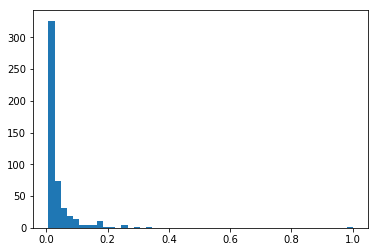

In [544]:
plt.hist(mrr_list_all,bins=50)

### 4. evaluate test data using MRR

In [545]:
test_prediction = predictions.loc[0:test_size_r-1,0:test_size_c-1]
test_prediction.shape
c_name = ["p_"+str(i) for i in range(28)]
test_prediction.columns = c_name
#test_prediction

final_check_df = pd.DataFrame(final_check.values)
final_check_df.columns = c_name
#final_check_df

In [546]:
"""
check the mean reciprocal rank of the first test data 
"""
session_i = final_check_df.loc[0]
session_i_new = session_i[session_i>0]
session_i_index = list(session_i_new.index)
#print(session_i_index)

test_i = test_prediction.loc[0]
test_i_rank = test_i.sort_values(ascending = False)
test_i_index = list(test_i_rank.index)
#print(test_i_rank)

list_rr = []
for product_real in session_i_index:
    index = test_i_index.index(product_real)
    rank = index+1
    RR = 1/rank
    list_rr.append(RR)
    print(rank)
mrr = np.mean(list_rr)
print(mrr)   

28
0.0357142857143


In [547]:
"""
get the mrr for the whole test data
"""
mrr_list_test = []
for i in range(test_size_r):
    session_i = final_check_df.loc[i]
    session_i_new = session_i[session_i>0]
    session_i_index = list(session_i_new.index)
    
    test_i = test_prediction.loc[i]
    test_i_rank = test_i.sort_values(ascending = False)
    test_i_index = list(test_i_rank.index)
    
    if len(session_i_index) != 0:
        list_rr = []
        for product_real in session_i_index:
            index = test_i_index.index(product_real)
            rank = index+1
            RR = 1/rank
            list_rr.append(RR)
        mrr = np.mean(list_rr)
        mrr_list_test.append(mrr)
#print(mrr_list_test)

In [548]:
MRR = np.mean(mrr_list_test)
MRR

0.13615196526265538

(array([ 5.,  4.,  2.,  1.,  2.,  1.,  2.,  1.,  1.,  0.,  2.,  0.,  1.,
         0.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.]),
 array([ 0.03571429,  0.04307407,  0.05043386,  0.05779365,  0.06515344,
         0.07251323,  0.07987302,  0.0872328 ,  0.09459259,  0.10195238,
         0.10931217,  0.11667196,  0.12403175,  0.13139153,  0.13875132,
         0.14611111,  0.1534709 ,  0.16083069,  0.16819048,  0.17555026,
         0.18291005,  0.19026984,  0.19762963,  0.20498942,  0.21234921,
         0.21970899,  0.22706878,  0.23442857,  0.24178836,  0.24914815,
         0.25650794,  0.26386772,  0.27122751,  0.2785873 ,  0.28594709,
         0.29330688,  0.30066667,  0.30802646,  0.31538624,  0.32274603,
         0.33010582,  0.33746561,  0.3448254 ,  0.35218519,  0.35954497,
         0.36690476,  0.37426455,  0.38162434,  0.38898413,

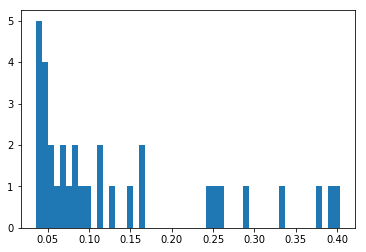

In [549]:
plt.hist(mrr_list_test,bins=50)